## Focal loss在xgboost上的效果探究

In [2]:
# coding=utf-8
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.decomposition import PCA
import numpy as np
import xgboost as xgb

def draw_roc_and_calculate_auc(models, modelnames, colors, X_test, y_test):  # 把models的roc曲线(和auc值)画到一张图
    N = len(models)  # 输入的是N个模型
    y_test_pred_prob = [0] * N  
    auc = [0] * N
    FPR = [0] * N
    TPR = [0] * N
    plt.figure()
    for i in range(N):
        y_test_pred_prob[i] = models[i].predict(X_test)
        auc[i] = roc_auc_score(y_test, y_test_pred_prob[i], average='macro')
        FPR[i], TPR[i], _ = roc_curve(y_test, y_test_pred_prob[i])
        plt.plot(FPR[i], TPR[i], color=colors[i], label=modelnames[i] + ':AUC=%.4f' % auc[i])
    plt.plot([0, 1], [0, 1], '--', color='black')  # diagonal line
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()


def draw_confusion_metrics(model, modelname, X_test, y_test):  # 把model的混淆矩阵画出来  #这个同时写很多的话不知道怎么安排画布就没写sos
    plt.figure()

    y_test_pred=(model.predict(X_test) >= 0.5).astype("int32")

    # # y_test_pred = model.predict(X_test)  # 上面那行有时候会报错，如果模型直接是classifier用这行就行
    # y_test_pred = model.predict_proba(X_test)[:, 1]  # 取第二列 正的概率，根据每个人的数据不同而不同!
    # y_test_pred = np.around(y_test_pred, 0).astype(int)

    c_matrix = confusion_matrix(y_test, y_test_pred)
    ax = sns.heatmap(c_matrix, annot=True, fmt="d",
                     xticklabels=['0', '1'],
                     yticklabels=['0', '1'],  
                     cbar=False, cmap='Blues')
    ax.set_xlabel("Prediction")
    ax.set_ylabel("Actual")
    plt.title(modelname)
    plt.show()


plt.rcParams.update({'figure.autolayout': True})

####导入数据
df = pd.read_csv("E:/Desktop/train_after_FeatureEngineer.csv")

df_X = df.drop(['target', 'id'], axis=1)
X = df_X.loc[:, :]
Y = df.loc[:, 'target']
X = X.to_numpy()
y = Y.to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.3,random_state=123)
dtrain = xgb.DMatrix(X_train,label=y_train)
dtest = xgb.DMatrix(X_test,label=y_test)

In [4]:
from scipy.misc import derivative
def focal_loss_lgb(y_pred, dtrain, alpha, gamma):
    a,g = alpha, gamma
    y_true = dtrain.get_label()
    def fl(x,t):
        p = 1/(1+np.exp(-x))
        return -(a * t + (1 - a) * (1 - t)) * ((1 - (t * p + (1 - t) * (1 - p))) ** g) * (
                t * np.log(p) + (1 - t) * np.log(1 - p))
    partial_fl = lambda x: fl(x, y_true)
    grad = derivative(partial_fl, y_pred, n=1)
    hess = derivative(partial_fl, y_pred, n=2)
    return grad, hess

In [5]:
params= {'max_depth': 2, 
          'eta': 0.01,
          'objective': 'binary:logistic', 
          'eval_metric': 'auc',
         'seed':0,
         'verbosity':0
         }

focal_loss0 = lambda x,y: focal_loss_lgb(x, y, 0.5, 0.)
focal_loss1 = lambda x,y: focal_loss_lgb(x, y, 0.95, 0.)
focal_loss2 = lambda x,y: focal_loss_lgb(x, y, 0.95, 1.)
focal_loss3 = lambda x,y: focal_loss_lgb(x, y, 0.95, 2.)
focal_loss4 = lambda x,y: focal_loss_lgb(x, y, 0.95, 4.)
focal_loss5 = lambda x,y: focal_loss_lgb(x, y, 0.95, 8.)

In [4]:
print("---------no focal loss-----------")
model1=xgb.train(params=params, 
                 dtrain=dtrain,
                 num_boost_round=400, 
                 maximize=True,
                 evals=[(dtrain, 'train'), (dtest, 'test')],
                 verbose_eval=50
                )

print("---------focal loss: alpha=0.5,gamma=0-----------")
model2=xgb.train(params=params, 
                 dtrain=dtrain,
                 num_boost_round=400, 
                 maximize=True,
                 evals=[(dtrain, 'train'), (dtest, 'test')],
                 verbose_eval=50,
                 obj=focal_loss0
                )

print("---------focal loss: alpha=0.95,gamma=0-----------")
model3=xgb.train(params=params, 
                 dtrain=dtrain,
                 num_boost_round=400, 
                 maximize=True,
                 evals=[(dtrain, 'train'), (dtest, 'test')],
                 verbose_eval=50,
                 obj=focal_loss1
                )

print("---------focal loss: alpha=0.95,gamma=1-----------")
model4=xgb.train(params=params, 
                 dtrain=dtrain,
                 num_boost_round=400, 
                 maximize=True,
                 evals=[(dtrain, 'train'), (dtest, 'test')],
                 verbose_eval=50,
                 obj=focal_loss2
                )

print("---------focal loss: alpha=0.95,gamma=2-----------")
model5=xgb.train(params=params, 
                 dtrain=dtrain,
                 num_boost_round=400, 
                 maximize=True,
                 evals=[(dtrain, 'train'), (dtest, 'test')],
                 verbose_eval=50,
                 obj=focal_loss3
                )

print("---------focal loss: alpha=0.95,gamma=4-----------")
model6=xgb.train(params=params, 
                 dtrain=dtrain,
                 num_boost_round=400, 
                 maximize=True,
                 evals=[(dtrain, 'train'), (dtest, 'test')],
                 verbose_eval=50,
                 obj=focal_loss4
                )

print("---------focal loss: alpha=0.95,gamma=8-----------")
model7=xgb.train(params=params, 
                 dtrain=dtrain,
                 num_boost_round=400, 
                 maximize=True,
                 evals=[(dtrain, 'train'), (dtest, 'test')],
                 verbose_eval=50,
                 obj=focal_loss5
                )



---------no focal loss-----------
[0]	train-auc:0.56792	test-auc:0.56404
[50]	train-auc:0.60665	test-auc:0.59871
[100]	train-auc:0.60769	test-auc:0.59950
[150]	train-auc:0.60960	test-auc:0.60121
[200]	train-auc:0.61321	test-auc:0.60436
[250]	train-auc:0.61644	test-auc:0.60733
[300]	train-auc:0.62032	test-auc:0.61145
[350]	train-auc:0.62407	test-auc:0.61484
[399]	train-auc:0.62680	test-auc:0.61726
---------focal loss: alpha=0.5,gamma=0-----------
[0]	train-auc:0.56792	test-auc:0.56404
[50]	train-auc:0.59977	test-auc:0.59285
[100]	train-auc:0.60761	test-auc:0.59947
[150]	train-auc:0.60933	test-auc:0.60103
[200]	train-auc:0.61300	test-auc:0.60447
[250]	train-auc:0.61679	test-auc:0.60741
[300]	train-auc:0.62091	test-auc:0.61195
[350]	train-auc:0.62470	test-auc:0.61540
[399]	train-auc:0.62758	test-auc:0.61790
---------focal loss: alpha=0.95,gamma=0-----------
[0]	train-auc:0.57762	test-auc:0.57021
[50]	train-auc:0.61193	test-auc:0.60326
[100]	train-auc:0.61967	test-auc:0.61069
[150]	train-a

In [5]:
focal_loss6 = lambda x,y: focal_loss_lgb(x, y, 0.95, 10.)
print("---------focal loss: alpha=0.95,gamma=10-----------")
model8=xgb.train(params=params, 
                 dtrain=dtrain,
                 num_boost_round=400, 
                 maximize=True,
                 evals=[(dtrain, 'train'), (dtest, 'test')],
                 verbose_eval=50,
                 obj=focal_loss6
                )

---------focal loss: alpha=0.95,gamma=10-----------
[0]	train-auc:0.57762	test-auc:0.57021
[50]	train-auc:0.61860	test-auc:0.60960
[100]	train-auc:0.62701	test-auc:0.61776
[150]	train-auc:0.63255	test-auc:0.62265
[200]	train-auc:0.63578	test-auc:0.62507
[250]	train-auc:0.63857	test-auc:0.62736
[300]	train-auc:0.64136	test-auc:0.62931
[350]	train-auc:0.64347	test-auc:0.63059
[399]	train-auc:0.64517	test-auc:0.63158


In [11]:
focal_loss7 = lambda x,y: focal_loss_lgb(x, y, 0.95, 20.)
print("---------focal loss: alpha=0.95,gamma=20-----------")
model9=xgb.train(params=params, 
                 dtrain=dtrain,
                 num_boost_round=500, 
                 maximize=True,
                 evals=[(dtrain, 'train'), (dtest, 'test')],
                 verbose_eval=50,
                 obj=focal_loss7
                )

---------focal loss: alpha=0.95,gamma=20-----------
[0]	train-auc:0.57729	test-auc:0.56993
[50]	train-auc:0.62340	test-auc:0.61459
[100]	train-auc:0.63272	test-auc:0.62225
[150]	train-auc:0.63664	test-auc:0.62561
[200]	train-auc:0.64034	test-auc:0.62859
[250]	train-auc:0.64298	test-auc:0.63028
[300]	train-auc:0.64471	test-auc:0.63128
[350]	train-auc:0.64610	test-auc:0.63207
[400]	train-auc:0.64737	test-auc:0.63256
[450]	train-auc:0.64860	test-auc:0.63310
[499]	train-auc:0.64956	test-auc:0.63343


In [7]:
#嗯，太贪心就会梯度消失？
print("gamma太大会梯度消失")
focal_loss8 = lambda x,y: focal_loss_lgb(x, y, 0.95, 30.)
print("---------focal loss: alpha=0.95,gamma=30-----------")
model10=xgb.train(params=params, 
                 dtrain=dtrain,
                 num_boost_round=200, 
                 maximize=True,
                 evals=[(dtrain, 'train'), (dtest, 'test')],
                 verbose_eval=50,
                 obj=focal_loss8
                )

gamma太大会梯度消失
---------focal loss: alpha=0.95,gamma=30-----------
[0]	train-auc:0.50000	test-auc:0.50000
[50]	train-auc:0.50000	test-auc:0.50000
[100]	train-auc:0.50000	test-auc:0.50000
[150]	train-auc:0.50000	test-auc:0.50000
[199]	train-auc:0.50000	test-auc:0.50000


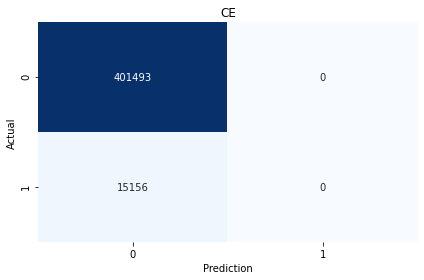

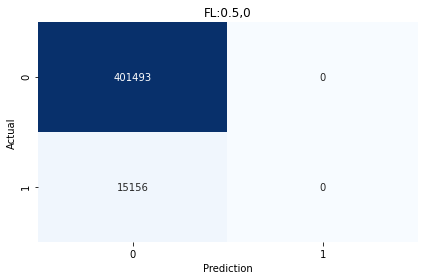

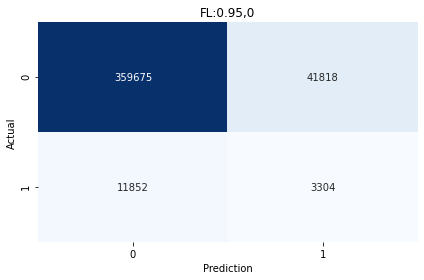

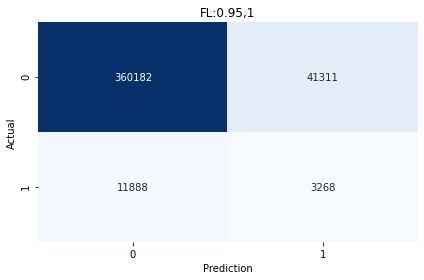

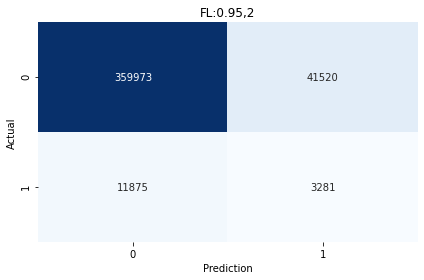

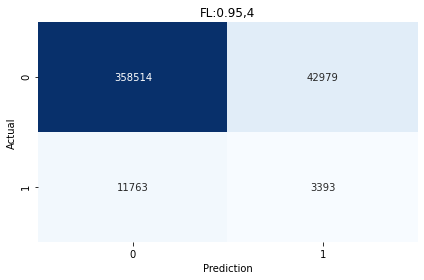

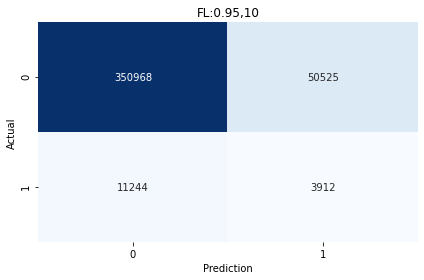

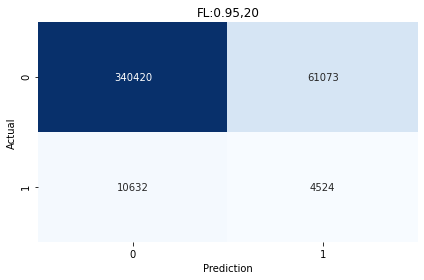

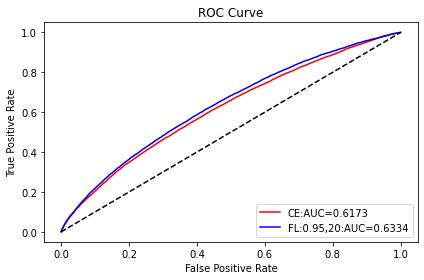

In [11]:
# #
# draw_confusion_metrics(model=model1,modelname='CE',X_test=dtest,y_test=y_test)
# draw_confusion_metrics(model=model9,modelname='FL:alpha=0.95,gamma=20',X_test=dtest,y_test=y_test)
# draw_confusion_metrics(model=model11,modelname='FL:alpha=0.5,gamma=20',X_test=dtest,y_test=y_test)

models=[model1,model2,model3,model4,model5,model6,model8,model9]
modelnames=['CE','FL:0.5,0','FL:0.95,0','FL:0.95,1','FL:0.95,2','FL:0.95,4','FL:0.95,10','FL:0.95,20']
for i,model in enumerate(models):
    draw_confusion_metrics(model=models[i],modelname=modelnames[i],X_test=dtest,y_test=y_test)


#
draw_roc_and_calculate_auc(models=[model1,model9],modelnames=['CE','FL:0.95,20'],colors=['red','blue'],X_test=dtest,y_test=y_test)


### 从上述结果可以看出，当alpha=0.5，gamma=0时（model2），模型结果与原模型（普通交叉熵）的效果基本一样，这也与我们的原理分析相契合。当alpha=0.95，gamma=0（model3），这时相当于对1类加权，此时模型效果有一定提升。当逐步提升gamma值时，相当于对困难样本更加关注，此时模型效果也有一定提升。最终测试集AUCscore从0.61726升到0.6334，说明Focal loss不失为一种较好的数据不均时的损失函数选择。

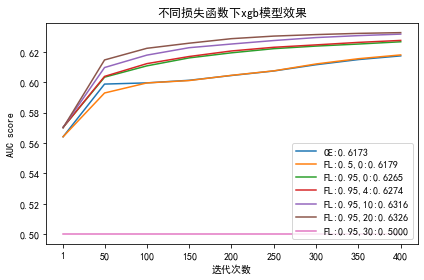

In [5]:
'''找不到怎么输出xgb每轮的评价TT只能复制一下手敲了
---------no focal loss-----------
[0.56404,0.59871,0.59950,0.60121,0.60436,0.60733,0.61145,0.61484,0.61726]
---------focal loss: alpha=0.5,gamma=0-----------
[0.56404,0.59285,0.59947,0.60103,0.60447,0.60741,0.61195,0.61540,0.61790]
---------focal loss: alpha=0.95,gamma=0-----------
[0.57021,0.60326,0.61069,0.61594,0.61928,0.62201,0.62371,0.62505,0.62654]
---------focal loss: alpha=0.95,gamma=1-----------
[0.57021,0.60317,0.61064,0.61564,0.61901,0.62183,0.62348,0.62487,0.62630]
---------focal loss: alpha=0.95,gamma=2-----------
[0.57021,0.60333,0.61065,0.61581,0.61913,0.62189,0.62370,0.62496,0.62639]
---------focal loss: alpha=0.95,gamma=4-----------
[0.57021,0.60376,0.61216,0.61685,0.62050,0.62292,0.62450,0.62614,0.62744]
---------focal loss: alpha=0.95,gamma=8-----------
[0.57021,0.60773,0.61587,0.62089,0.62372,0.62578,0.62768,0.62935,0.63036]
---------focal loss: alpha=0.95,gamma=10-----------
[0.57021,0.60960,0.61776,0.62265,0.62507,0.62736,0.62931,0.63059,0.63158]
---------focal loss: alpha=0.95,gamma=20-----------
[0.56993,0.61459,0.62225,0.62561,0.62859,0.63028,0.63128,0.63207,0.63256]

'''

#设置字符集，防止中文乱码
plt.rcParams['font.sans-serif'] = [u'simHei']
plt.rcParams['axes.unicode_minus'] = False

aucs=[
[0.56404,0.59871,0.59950,0.60121,0.60436,0.60733,0.61145,0.61484,0.61726]
,
[0.56404,0.59285,0.59947,0.60103,0.60447,0.60741,0.61195,0.61540,0.61790]
,
[0.57021,0.60326,0.61069,0.61594,0.61928,0.62201,0.62371,0.62505,0.62654]
,
[0.57021,0.60376,0.61216,0.61685,0.62050,0.62292,0.62450,0.62614,0.62744]
,
[0.57021,0.60960,0.61776,0.62265,0.62507,0.62736,0.62931,0.63059,0.63158]
,
[0.56993,0.61459,0.62225,0.62561,0.62859,0.63028,0.63128,0.63207,0.63256]
,
[0.50000,0.50000,0.50000,0.50000,0.50000,0.50000,0.50000,0.50000,0.50000]]

labels=['CE','FL:0.5,0','FL:0.95,0','FL:0.95,4','FL:0.95,10','FL:0.95,20','FL:0.95,30']
xticks=[1,50,100,150,200,250,300,350,400]


plt.figure()
for i in range(len(labels)):
    plt.plot(xticks, aucs[i],label=labels[i]+':%.4f'%(aucs[i][8])) 
    
plt.title('不同损失函数下xgb模型效果')
plt.xticks(xticks)
plt.legend(loc='lower right')
plt.xlabel('迭代次数')
plt.ylabel('AUC score')
plt.show()